# Imports

In [25]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')

## Load Images - Dataset: You will use the CelebA dataset

In [26]:
dir_path = r"/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
def load_images(folder_path, img_size = (128, 128)):
    X = []
    limit = 40000
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:,:,::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)

img_size = 64
X_train = load_images(dir_path, (img_size, img_size))
X_train.shape

 20%|█▉        | 39999/202599 [01:47<07:18, 371.08it/s]


(40000, 64, 64, 3)

## Show Data

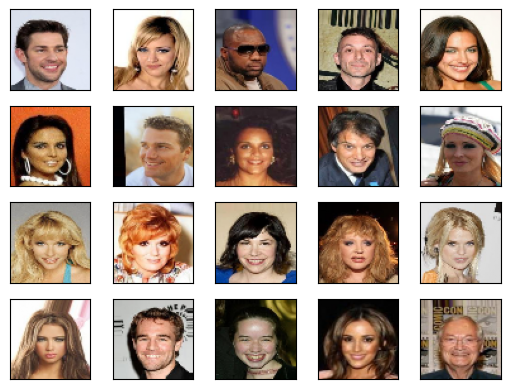

In [27]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
show_images(X_train)

# Create Gan.

In [28]:
Generator = Sequential([
    layers.Dense(8 * 8 * 128, input_shape = (128,)),
    layers.BatchNormalization(),

    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(256, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'sigmoid'),
])

In [29]:
Discriminator = Sequential([
    layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same', input_shape = (64, 64, 3)),
    layers.LeakyReLU(),

    layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1)
])

In [30]:
class GAN(Model):
    def __init__(self, Generator, Discriminator):
        super().__init__()
        self.latent_dim = 128
        self.generator = Generator
        self.discriminator = Discriminator
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def train_step(self, images):

        noise = tf.random.normal([images.shape[0], self.latent_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [31]:
model = GAN(Generator, Discriminator)

model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              criterion = tf.keras.losses.BinaryCrossentropy(True))

In [32]:
Generator.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,739 (6.43 MB)

 Trainable params: 1,667,587 (6.36 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [33]:
Discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,865 (1.45 MB)

 Trainable params: 380,481 (1.45 MB)

 Non-trainable params: 384 (1.50 KB)

## Train network

Epoch 1/35, Generator Loss: 2.625246047973633, Discriminator Loss: 0.29394325613975525
Epoch 2/35, Generator Loss: 2.0693187713623047, Discriminator Loss: 0.4568919837474823
Epoch 3/35, Generator Loss: 1.8010177612304688, Discriminator Loss: 0.6132336258888245
Epoch 4/35, Generator Loss: 1.6400275230407715, Discriminator Loss: 0.7066535949707031
Epoch 5/35, Generator Loss: 1.7756460905075073, Discriminator Loss: 0.6245722770690918
Epoch 6/35, Generator Loss: 1.8415231704711914, Discriminator Loss: 0.6763055920600891
Epoch 7/35, Generator Loss: 1.7009528875350952, Discriminator Loss: 0.721966564655304
Epoch 8/35, Generator Loss: 1.7522151470184326, Discriminator Loss: 0.7789224982261658
Epoch 9/35, Generator Loss: 1.8745530843734741, Discriminator Loss: 0.7014990448951721
Epoch 10/35, Generator Loss: 1.801393747329712, Discriminator Loss: 0.7157092094421387
Epoch 11/35, Generator Loss: 1.9251643419265747, Discriminator Loss: 0.665568470954895
Epoch 12/35, Generator Loss: 2.0994691848754

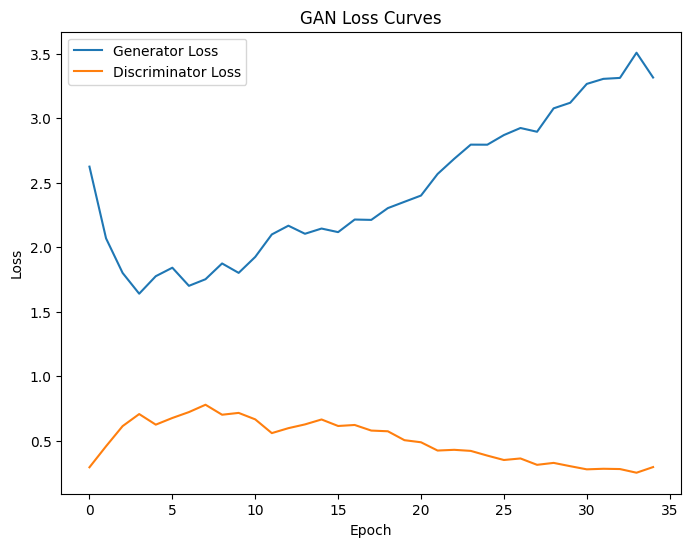

In [34]:
import numpy as np

# Assuming you've already compiled the model
generator_losses = []
discriminator_losses = []

# Set the number of epochs and batch size
epochs = 35
batch_size = 100

# Custom training loop
for epoch in range(epochs):
    epoch_gen_loss = []
    epoch_disc_loss = []
    
    # Iterate over the dataset in batches
    for batch in range(len(X_train) // batch_size):
        images = X_train[batch * batch_size:(batch + 1) * batch_size]
        losses = model.train_step(images)
        epoch_gen_loss.append(losses["Generator Loss"])
        epoch_disc_loss.append(losses["Discriminator Loss"])
    
    # Compute the mean loss for the epoch
    generator_losses.append(np.mean(epoch_gen_loss))
    discriminator_losses.append(np.mean(epoch_disc_loss))
    
    print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {generator_losses[-1]}, Discriminator Loss: {discriminator_losses[-1]}")

# Now you can access and plot the generator and discriminator losses
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Loss Curves')
plt.legend()
plt.show()

## Test - given random noise.

In [35]:
fixed_noise = tf.random.normal((60, 128))
print(fixed_noise)

tf.Tensor(
[[ 0.9923629   1.2771208   0.8788012  ...  0.14522314  0.22303945
  -0.10977326]
 [ 0.13274214  0.21315767  0.15663506 ... -0.6969079  -0.06453937
  -1.2410172 ]
 [-1.6501439  -1.2003243   0.97094876 ...  0.8331922  -1.2684764
   0.7113255 ]
 ...
 [ 0.3689495  -0.9927268   0.4895485  ...  0.99404156 -0.31618994
  -0.21827608]
 [ 1.1144521  -0.6057554   0.8927197  ...  0.6155887  -0.34808066
  -1.1660179 ]
 [-1.4351989   0.03489948  0.5134653  ... -0.46655127 -1.2927756
   1.2948359 ]], shape=(60, 128), dtype=float32)


### Output visualization: Generate images from your model and visualize its latent spaces

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


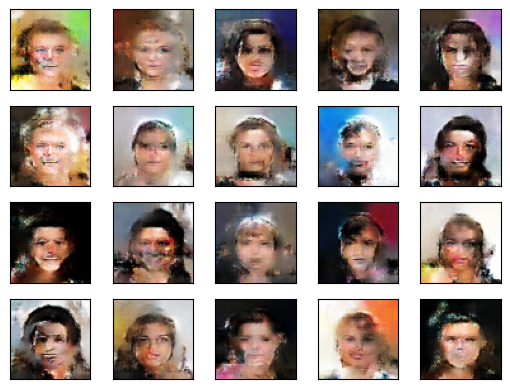

In [36]:
fixed_noise = tf.random.normal((60, 128))
y_pred = model.generator.predict(fixed_noise)
show_images(y_pred)

## Save Gan

In [37]:
model.generator.save_weights('./gen.weights.h5')
model.discriminator.save_weights('./disc.weights.h5')


### Reproduce

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


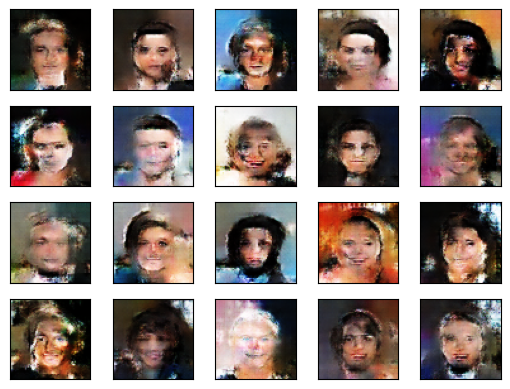

In [38]:
from tensorflow.keras.models import load_model

def reproduce_hw3(model):
    fixed_noise = tf.random.normal((60, 128))
    y_pred = model.generator.predict(fixed_noise)
    show_images(y_pred)
    
gen = Generator
gen.load_weights('./gen.weights.h5')
disc = Discriminator
disc.load_weights('./disc.weights.h5')
model = GAN(Generator, Discriminator)

model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              criterion = tf.keras.losses.BinaryCrossentropy(True))
reproduce_hw3(model)
    